In [1]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, concatenate
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
import cv2

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import seaborn as sns

from keras.callbacks import EarlyStopping

import random


from tensorflow.keras.callbacks import TensorBoard
import time

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

from keras.regularizers import l2

In [2]:
NAME = f"dementia_one_vs_all_{int(time.time())}"
tensorboard = TensorBoard(log_dir = "./logs/final/Final/final{}".format(NAME))

BS = 32

In [3]:
folder = "C:/Users/mohdf/OneDrive/Desktop/oasis/data/organised_mr"

# 0 -> mri
# 1 -> non_mri

zero = []
   
for dirname, _, filenames in os.walk(folder+'/0.0'):
    for filename in filenames:
        zero.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(folder+'/0.5'):
    for filename in filenames:
        zero.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(folder+'/1.0'):
    for filename in filenames:
        zero.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(folder+'/2.0'):
    for filename in filenames:
        zero.append(os.path.join(dirname, filename))


In [4]:
(cifar_train_images, _), (cifar_test_images, _) = tf.keras.datasets.cifar10.load_data()

# Use only a subset of CIFAR-10 to balance the dataset
non_mri_images = np.concatenate((cifar_train_images, cifar_test_images), axis=0)
non_mri_labels = [1] * len(non_mri_images)

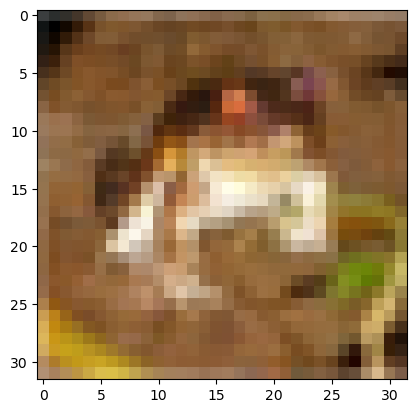

In [5]:
plt.imshow(non_mri_images[0])

In [6]:
len(non_mri_images), len(zero)

(60000, 112091)

In [7]:
mri_images = random.sample(zero, k = len(non_mri_images))
mri_labels = [0] * len(mri_images)

In [8]:
len(non_mri_images), len(mri_images)

(60000, 60000)

In [9]:
# Combine MRI and non-MRI images
all_images = []
for elem in mri_images:
    all_images.append(elem)
for elem in non_mri_images:
    all_images.append(elem)   

all_labels = mri_labels + non_mri_labels

In [10]:
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

len(train_images), len(test_images)

(96000, 24000)

In [11]:
def image_generator(image_paths, image_labels, batch_size=32):
    while True:
        for i in range(0, len(image_paths), batch_size):
            image_batch = image_paths[i:i+batch_size]
            label_batch = image_labels[i:i+batch_size]
            
            # Load and process the images in this batch
            image_array = []
            for j, path in enumerate(image_batch):
                if label_batch[j] == 0:
                    image = cv2.imread(path)
                    image = cv2.resize(image, (32,32))
                else:
                    image = cv2.resize(path,(32,32))
                image_array.append(image)

            image_array = np.array(image_array) / 255.0
            label_array = np.array(label_batch)

            yield image_array, label_array

train_generator = image_generator(train_images, train_labels)
test_generator = image_generator(test_images, test_labels)

In [12]:
from tensorflow.keras.applications import VGG16

In [13]:

image_input = Input(shape=(32, 32, 3))

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model layers to preserve pre-trained features
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model(image_input)
x = Flatten()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x) 



In [14]:
model = Model(inputs=image_input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(),'accuracy'])

In [15]:
batch_size = BS
steps_per_epoch = len(train_images) // batch_size 

history = model.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs=2,
    callbacks=[tensorboard]
)

Epoch 1/2
3000/3000 [==============================] - 334s 109ms/step - loss: 0.0619 - precision: 0.9861 - accuracy: 0.9845
Epoch 2/2
3000/3000 [==============================] - 299s 100ms/step - loss: 0.0205 - precision: 0.9948 - accuracy: 0.9939


In [16]:
test_steps = len(test_images) // batch_size 
loss_and_metrics = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {loss_and_metrics[0]}")
print(f"Test precision: {loss_and_metrics[1]}")
print(f"Test Accuracy: {loss_and_metrics[2]}")

750/750 [==============================] - 84s 112ms/step - loss: 0.0088 - precision: 0.9970 - accuracy: 0.9975
Test Loss: 0.008793411776423454
Test precision: 0.9970359206199646
Test Accuracy: 0.9974583387374878


In [62]:

test_generator = image_generator(test_images, test_labels)

test_steps = len(test_images) // batch_size
predictions = model.predict(test_generator, steps=test_steps)

predicted_labels = (predictions[:] > 0.5).astype(int)

test_generator = image_generator(test_images, test_labels)

# True labels
true_labels = []
for i in range(test_steps):
    _, labels = next(test_generator)
    true_labels.extend(labels)

# Classification Report
class_names = ['0', '1']
report = classification_report(true_labels, predicted_labels, target_names=class_names, labels=['0', '1'], zero_division=1)
print("Classification Report:")
print(report)

750/750 [==============================] - 79s 105ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12201
           1       1.00      1.00      1.00     11799

   micro avg       1.00      1.00      1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000



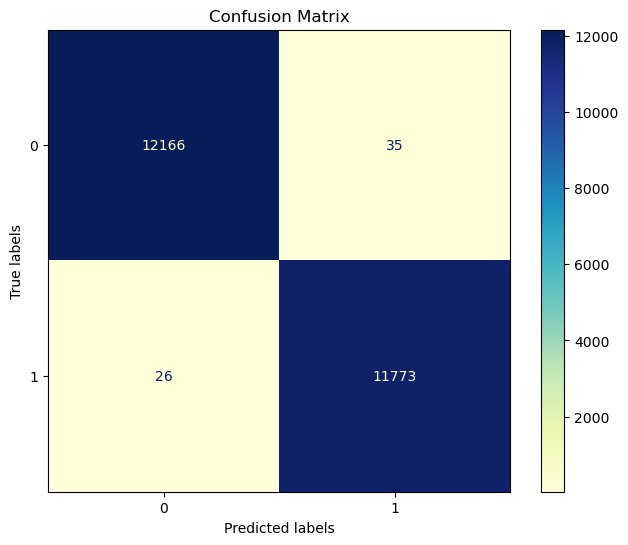

In [63]:
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size as needed

# Plot the confusion matrix on the specified axis with the desired colormap
disp.plot(ax=ax, cmap='YlGnBu')

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Display the plot
plt.show()

In [156]:
# small_folder = "C:/Users/mohdf/OneDrive/Desktop/oasis/data/small"
# small_images = []
# for dirname, _, filenames in os.walk(small_folder+'/0.0'):
#     for filename in filenames:
#         small_images.append(os.path.join(dirname, filename))

# for dirname, _, filenames in os.walk(small_folder+'/0.5'):
#     for filename in filenames:
#         small_images.append(os.path.join(small_folder, filename))

# for dirname, _, filenames in os.walk(small_folder+'/1.0'):
#     for filename in filenames:
#         small_images.append(os.path.join(dirname, filename))

# for dirname, _, filenames in os.walk(small_folder+'/2.0'):
#     for filename in filenames:
#         small_images.append(os.path.join(dirname, filename))

# small_prediction = []
# for img in small_images:
#     imgTest = cv2.imread(img)
#     resize = tf.image.resize(imgTest, (32,32))
#     model_prediction = validator_model.predict(np.expand_dims(resize/255,0))
#     small_prediction.append(model_prediction[0][0])

In [158]:
# small_prediction_desc = np.sort(small_prediction)[::-1]

In [159]:
# small_prediction_desc[0:50]

In [20]:
model.save(os.path.join("images_validator3.h5"))

In [2]:
from tensorflow.keras.models import load_model

In [3]:
validator_model = load_model(os.path.join("images_validator3.h5"))

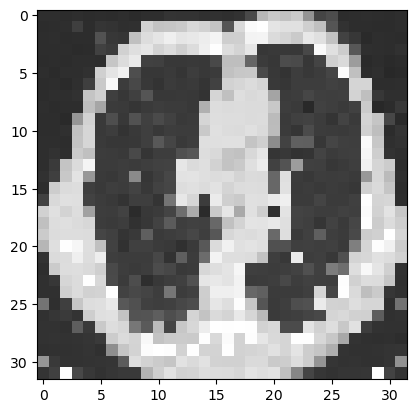

In [8]:
base = "C:/Users/mohdf/OneDrive/Desktop/oasis/data/organised_mr/"

path = "0.0/OAS30001_MR_d0129_anat2_19.jpg"
path = "0.0/OAS30002_MR_d2340_anat2_26.jpg"
path = "0.0/OAS30216_MR_d3830_anat2_18.jpg"
path = "0.0/OAS30219_MR_d0064_anat2_15.jpg"
path = "0.0/OAS30770_MR_d1201_anat1_17.jpg"

path = "0.5/OAS30007_MR_d2722_anat2_24.jpg"
path = "0.5/OAS30035_MR_d3850_anat1_13.jpg"
# path = "0.5/OAS30159_MR_d0110_anat1_8.jpg"
# path = "0.5/OAS30250_MR_d3004_anat2_30.jpg"
# path = "0.5/OAS30553_MR_d0822_anat2_25.jpg"


# path = "1.0/OAS30029_MR_d0893_anat2_76.jpg"
# path = "1.0/OAS30029_MR_d0893_anat2_157.jpg"
# path = "1.0/OAS30914_MR_d0108_anat2_99.jpg"
# path = "1.0/OAS31170_MR_d2410_anat2_31.jpg"
# path = "1.0/OAS30399_MR_d2293_anat2_154.jpg"

# path =  "2.0/OAS30994_MR_d0070_anat2_138.jpg"
# path =  "2.0/OAS30098_MR_d0036_anat1_125.jpg"
# path =  "2.0/OAS30194_MR_d9874_anat2_110.jpg"
# path =  "2.0/OAS30661_MR_d0057_anat1_20.jpg"
# path =  "2.0/OAS31135_MR_d0498_anat1_46.jpg"

full_path = base + path
# full_path = "C:/Users/mohdf/OneDrive/Desktop/cat.jpg"
full_path = "C:/Users/mohdf/OneDrive/Desktop/car.jpg"
# full_path = "C:\Faheem\Faheem documents\Faheem .jpg"
# full_path = "C:\Faheem\Faheem documents\Faheem.jpg"
# full_path = "C:\Faheem\Faheem documents\img101.jpg"
# full_path = "C:/Users/mohdf/OneDrive/Desktop/lung.jpg"
# full_path = "C:/Users/mohdf/OneDrive/Desktop/lung01.jpg"
# full_path = "C:/Users/mohdf/OneDrive/Desktop/cat03.jpg"
# full_path = "C:/Users/mohdf/OneDrive/Desktop/lung02.jpg"
# full_path = "C:/Users/mohdf/OneDrive/Desktop/lung03.jpg"
full_path = "C:/Users/mohdf/OneDrive/Desktop/lung04.jpg"
imgTest = cv2.imread(full_path)
resize = tf.image.resize(imgTest, (32,32))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [9]:
model_prediction = validator_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 63ms/step


In [10]:
print(model_prediction[0][0])
# for predictions in model_prediction[0]:
#     print(predictions)

0.36381572


In [11]:

if model_prediction[0][0] > 0.1:
    print("invalid MRI")
else:
    print("valid MRI")

invalid MRI
